# Telco Custumer Churn

Neste projeto irei construir um modelo de machine learnig para prever a possibilidade de um cliente cancelar o contrato com uma operadora de telecomunicações. Trata-se de um problema de aprendizado supervisionado (utilizando um conjunto de dados rotulado) de classificação, em que o alvo (target) é 1 se o cliente cancelou o serviço e 0 caso contrário.

Pipiline de resolução usado no projeto(baseado no CRISPIM-DM)
1. Definir o problema de negócio.

2. Coletar os dados e obter uma visão geral deles.

3. Dividir os dados em conjuntos de treino e teste.

4. Explorar os dados (Análise Exploratória de Dados – EDA).

5. Engenharia de atributos, limpeza e pré-processamento dos dados.

6. Treinamento dos modelos, comparação, seleção de atributos e ajuste de hiperparâmetros.

7. Teste final do modelo em produção e avaliação.

8. Conclusão e interpretação dos resultados do modelo.

9. Implantação (deploy).


Neste notebook, irei realizar a modelagem de machine learning, cobrindo as etapas 5 a 8 do pipeline apresentado acima. O principal objetivo aqui é construir um modelo que possa prever com precisão a probabilidade de um cliente cancelar (churn). Após construir esse modelo, a empresa de telecomunicações podera prever a probabilidade de um cliente sair, e direcionar suas estratégias para retenção e fidelização do cliente. Adquirir novos clientes é mais caro do que manter os existentes. Além disso, abordarei essas etapas em detalhes a seguir, explicando o motivo de cada decisão tomada.


In [1]:
# Funções nativas 
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from src.data_prep import preprocess_basic, ChurnTransformer
from src.modell_utils import evaluate_models

# Visualização e manipulação do dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import LinearSegmentedColormap


import warnings
warnings.filterwarnings('ignore') # Silencia todos os avisos irritantes


## Carregando os dados 

In [2]:
data_patch = '../data/WA_Fn-UseC_-Telco-Customer-Churn.xls'

df = pd.read_csv(data_patch)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## Limpeza

Para otimizar a performance e a interpretabilidade do modelo, realizarei a exclusão de variáveis que não contribuem significativamente para o poder preditivo:

* customerID: Removido por tratar-se de um identificador único de natureza administrativa, sem valor estatístico para o aprendizado do modelo.

* gender: Excluído após a EDA demonstrar que a distribuição de Churn é praticamente idêntica entre os gêneros, não apresentando ganho de informação (Information Gain) relevante.

* TotalCharges: Conforme observado na análise de correlação, esta variável apresenta altíssima colinearidade com o tenure (r=0.83). Em modelos lineares, como a Regressão Logística, a presença de variáveis redundantes pode inflar os erros padrão e dificultar a identificação da real importância de cada atributo (problema de multicolinearidade)."

* Além disso, irei padronizar o nome da coluna tenure. 

In [5]:
df = preprocess_basic(df)

## 3. Separando os dados entre treino e test (Split)

* Irei separar os dados entre treino e teste para evitar o DataLekage, e garantir a capacidade de genereralização do modelo. 

In [6]:
X = df.drop(columns = ['Churn'])
y = df['Churn'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state =42)

print(f"Treino: {X_train.shape[0]} amostras | Teste: {X_test.shape[0]} amostras")

Treino: 5634 amostras | Teste: 1409 amostras


In [7]:
print(f"Treino: {y_train.value_counts(normalize = True)}")
print(f"Teste: {y_test.value_counts(normalize = True)}")

Treino: Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64
Teste: Churn
0    0.734564
1    0.265436
Name: proportion, dtype: float64


* as proporções entre treino e teste foram mantidas.

## 5. Engenharia de atributos, limpeza e pré-processamento dos dados.



Nesta próxima etapa, transformarei os dados brutos em sinais claros e acionáveis para os algoritmos. O foco não será apenas a "limpeza", mas sim garantir que o modelo final esteja protegido contra viés, vazamento de dados (*data leakage*) e instabilidade numérica.

Abaixo, detalho as decisões estratégicas que implementarei na preparação do dataset:


#### 1. Engenharia de Atributos (Feature Engineering)

* Embora eu remova a variável TotalCharges original para evitar multicolinearidade com tenure, criarei novas métricas para capturar padrões:

* **Serviços De Segurança:** Criarei uma contagem de quantos serviços extras o cliente possui ('TechSupport', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection').Vimos que os clientes que utilizam esses serviços tem baixa aderencia de churn. Usaremos essa informação para identificar os clientes que não utilizam esse serviço, e que consequentemente tem mais propensão ao churn.
  
* **Segmentação de Faturamento:** Realizarei a binatização de faturas muito acima da média para identificar explicitamente o "choque de preço" notado na EDA.

#### 2. Codificação de Variáveis Categóricas (Encoding)

* Como os modelos matemáticos não interpretam texto, traduzirei as categorias em números, tomando cuidado para não criar hierarquias falsas:

* **One-Hot Encoding (OHE):** Aplicarei em variáveis como PaymentMethod. Para evitar a "Armadilha da Variável Dummy", utilizarei o parâmetro drop='first, removendo colunas redundantes.
* **Ordinal/Binary Encoding:** Para variáveis "Yes/No", utilizarei uma codificação binária simples (0 e 1), mantendo o dataset leve.

#### 3. Escalonamento de Atributos (Feature Scaling)

* Para garantir o bom desempenho de algoritmos sensíveis à escala (baseados em distância ou gradiente), padronizarei os dados numéricos.

* **StandardScaler:**  Irei apliacr o StandardScaler para padronizar as variáveis numéricas. Como os algoritmos de Machine Learning são sensíveis à magnitude dos números, a padronização garante que todas as variáveis contribuam igualmente para o modelo, evitando que atributos com escalas maiores (como cobranças mensais) dominem o aprendizado em detrimento de variáveis binárias ou de menor escala.
* **Prevenção de Data Leakage:** Garantirei que o *fit* do escalonador seja feito **exclusivamente no conjunto de treino**. O conjunto de teste será apenas transformado, simulando dados inéditos em produção.





In [8]:
df_train_pre_proced = pd.concat([X_train, y_train], axis = 1)

df_train_pre_proced.head(3)

,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Security_Svc_Count,Churn
3738,0,0,0,35,0,0,DSL,1,1,Month-to-month,0,Electronic check,49.20,1,0
3151,0,1,1,15,1,0,Fiber optic,0,0,Month-to-month,0,Mailed check,75.10,1,0
4860,0,1,1,13,0,0,DSL,0,0,Two year,0,Mailed check,40.55,3,0


In [9]:
df_test_pre_proced = pd.concat([X_test, y_test], axis = 1)

df_train_pre_proced.head(3)

,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Security_Svc_Count,Churn
3738,0,0,0,35,0,0,DSL,1,1,Month-to-month,0,Electronic check,49.20,1,0
3151,0,1,1,15,1,0,Fiber optic,0,0,Month-to-month,0,Mailed check,75.10,1,0
4860,0,1,1,13,0,0,DSL,0,0,Two year,0,Mailed check,40.55,3,0


* Irei chamar a função responsável por realizar todo processo descrito acima. 

In [10]:
#Instancia e usa a Classe que criamos
transformer = ChurnTransformer()
transformer.fit(df_train_pre_proced)

df_train = transformer.transform(df_train_pre_proced)
df_test = transformer.transform(df_test_pre_proced)

In [11]:
df_train.info()

<class 'pandas.DataFrame'>
Index: 5634 entries, 3738 to 5639
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          5634 non-null   int64  
 1   Partner                                5634 non-null   int64  
 2   Dependents                             5634 non-null   int64  
 3   Tenure                                 5634 non-null   float64
 4   PhoneService                           5634 non-null   int64  
 5   MultipleLines                          5634 non-null   int64  
 6   StreamingTV                            5634 non-null   int64  
 7   StreamingMovies                        5634 non-null   int64  
 8   PaperlessBilling                       5634 non-null   int64  
 9   MonthlyCharges                         5634 non-null   float64
 10  Security_Svc_Count                     5634 non-null   float64
 11  Churn            

### 6. Treinamento dos modelos, comparação, seleção de atributos e ajuste de hiperparâmetros.

* Nesta etapa, pretendo comparar o desempenho de diferentes modelos. Para isso, utilizarei a validação cruzada K-Fold estratificada para treinar cada um deles e avaliar sua pontuação ROC-AUC. A acurácia não é uma boa métrica porque o alvo é desbalanceado.
Para garantir a robustez estatística, optei pela Validação Cruzada K-Fold Estratificada (k=5). Esta técnica foi vital devido à natureza desbalanceada do Churn. Ela preserva a porcentagem de amostras de cada classe em cada dobra, permitindo que o modelo seja treinado e validado em subconjuntos que representam fielmente a realidade do negócio. 

* Em estratégias de prevenção ao Churn, o Recall é a nossa principal prioridade. Esta métrica avalia a capacidade do modelo de identificar corretamente os clientes que, de fato, iriam cancelar o serviço. Como o impacto financeiro de perder um cliente (Falso Negativo) costuma ser bastante elevado, nosso objetivo é garantir que o modelo consiga mapear o maior volume possível dessas evasões reais.

* Por outro lado, aplicar ações de retenção de forma indiscriminada — como oferecer descontos a toda a base — geraria custos insustentáveis para o negócio. A Precisão entra para garantir a eficiência operacional: ela assegura que, quando o modelo alerta sobre um possível cancelamento, a probabilidade de acerto é alta, evitando o desperdício de recursos com clientes que já permaneceriam na empresa (Falsos Positivos). Por fim, o F1-Score atua como o nosso indicador de balanço, ajudando a encontrar o cenário ideal entre a abrangência de detecção (Recall) e a assertividade das abordagens (Precisão).

In [12]:
#Instanciando modelos
models = {"Logistic Regression": LogisticRegression(class_weight = 'balanced', random_state=42), 
                "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
                "XGBoost": XGBClassifier(scale_pos_weight=3, random_state=42)
                }
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
X = df_train.drop(columns=['Churn']).values 
y = df_train['Churn'].values

#Função responsável por treinar o modelo
df_results = evaluate_models(X, y, models)

display(df_results)

🚀 Avaliando Logistic Regression...


🚀 Avaliando Random Forest...
🚀 Avaliando XGBoost...


,Model,Recall,Precision,F1-Score,ROC-AUC,Accuracy
0,Logistic Regression,0.796656,0.517183,0.627054,0.844771,0.748671
2,XGBoost,0.682943,0.533137,0.598706,0.816377,0.757189
1,Random Forest,0.460201,0.598583,0.520073,0.810180,0.774763


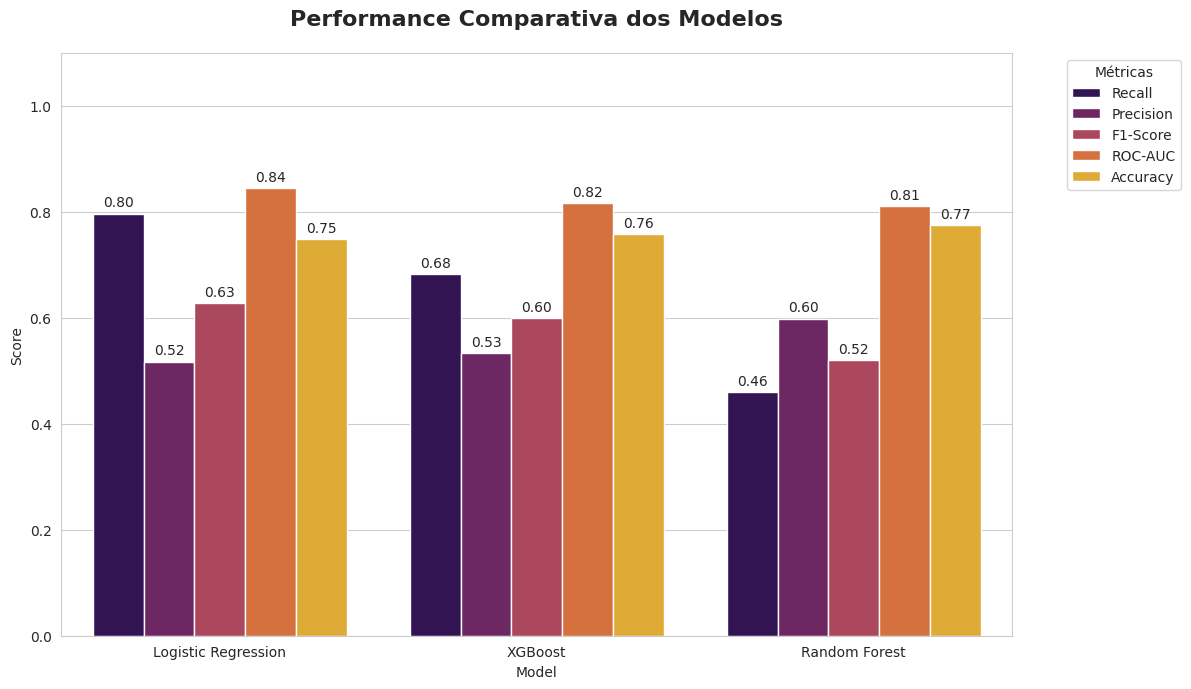

In [14]:
df_plot = df_results.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))


ax = sns.barplot(data=df_plot, x='Model', y='Score', hue='Metric', palette='inferno')

plt.title('Performance Comparativa dos Modelos', fontsize=16, fontweight='bold', pad=20)
plt.legend(title='Métricas', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1) 

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

Insigts:

* A  Regressão Logística  apresentou o melhor desempenho para o negócio. Com um Recall de 0.80 e um ROC-AUC de 0.84, ele foi capaz de identificar 80% dos clientes em risco de cancelamento. Este sucesso está diretamente ligado à nossa Engenharia de Atributos: variáveis como Security_Svc_Count e Is_Price_Shock criaram sinais lineares claros que o modelo explorou com precisão.

* O XGBoost entregou um desempenho mediano, com Recall de 0.68. Embora não seja um resultado ruim, ele ficou atrás da Regressão Logística por ainda não estar tunado. Na Ciência de Dados, seguimos o princípio de que, se um modelo simples performa tão bem quanto um complexo, o simples é a escolha ideal. A Regressão Logística é mais rápida, exige menos poder computacional e oferece algo valiosíssimo: Interpretabilidade total sobre as causas do Churn.

* O Random Forest apresentou o pior resultado para o nosso objetivo, com um Recall de apenas 0.46. Embora ele ostente a maior Acurácia (0.77), este caso prova que, em cenários de alvos desbalanceados, a acurácia é uma métrica ilusória. O modelo priorizou acertar quem fica, mas falhou em detectar quem sai — justamente o ponto mais crítico para a saúde financeira da empresa.

### Ajuste de Hiperparâmetros (Tuning)

* Como a Regressão Logística apresentou o melhor desempenho inicial, agora irei realizar o Ajuste de Hiperparâmetros (Tuning) para extrair a máxima performance deste modelo.

* Utilizarei o GridSearchCV para testar diferentes combinações de parâmetros, como a força da regularização (C) e o tipo de penalidade (l1 ou l2).

* Configurarei a busca para otimizar especificamente o Recall, garantindo que o modelo seja treinado para priorizar a identificação de clientes que realmente pretendem cancelar (evitando perdas de receita).

* Todo esse processo será sustentado pela Validação Cruzada K-Fold Estratificada, garantindo que as melhorias encontradas sejam consistentes em diferentes subconjuntos de dados e não apenas fruto de um ajuste isolado.

* Através da regularização, buscarei controlar o peso das variáveis, evitando o overfitting e garantindo que o modelo final seja enxuto, interpretável e pronto para ser aplicado em um cenário real de produção."


In [15]:

X = df_train.drop(columns=['Churn']).values 
y = df_train['Churn'].values
    
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],              
    'solver': ['liblinear']              
}

log_reg_base = LogisticRegression(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg_base,
    param_grid=param_grid,
    scoring='recall',      
    cv=skf,                
    n_jobs=-1,             
    verbose=1             
)

print("Iniciando a busca pelos melhores hiperparâmetros...")
grid_search.fit(X, y) 

print("\n--- Resultados do Tuning ---")
print(f"Melhores Parâmetros: {grid_search.best_params_}")
print(f"Melhor Recall Médio (Cross-Validation): {grid_search.best_score_:.4f}")

best_log_reg = grid_search.best_estimator_

Iniciando a busca pelos melhores hiperparâmetros...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- Resultados do Tuning ---
Melhores Parâmetros: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor Recall Médio (Cross-Validation): 0.8060


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1035
           1       0.49      0.82      0.61       374

    accuracy                           0.72      1409
   macro avg       0.70      0.75      0.70      1409
weighted avg       0.80      0.72      0.74      1409



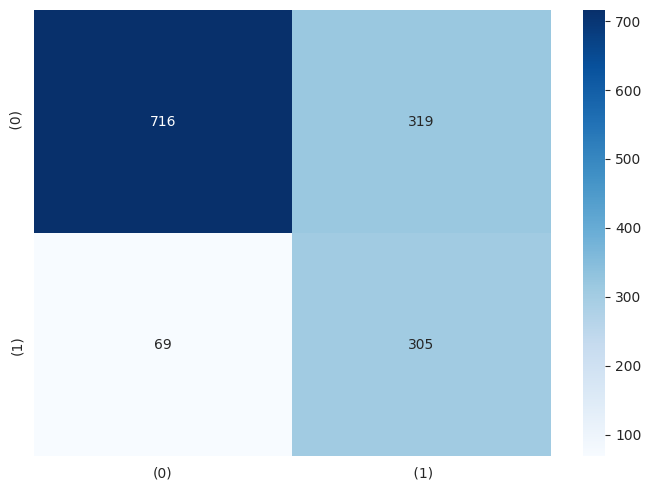

In [16]:

X_test = df_test.drop(columns=['Churn']).values
y_test = df_test['Churn'].values

y_pred = best_log_reg.predict(X_test)

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['(0)', ' (1)'], 
            yticklabels=[' (0)', '(1)'])

plt.tight_layout()
plt.show()

,Feature,Coeficiente
9,MonthlyCharges,0.282260
17,InternetService_Fiber optic,0.181905
15,PaymentMethod_Electronic check,0.175174
8,PaperlessBilling,0.106918
11,Is_Price_Shock,0.036145


,Feature,Coeficiente
3,Tenure,-0.412800
10,Security_Svc_Count,-0.207903
13,Contract_Two year,-0.202475
18,InternetService_No,-0.161193
12,Contract_One year,-0.133189


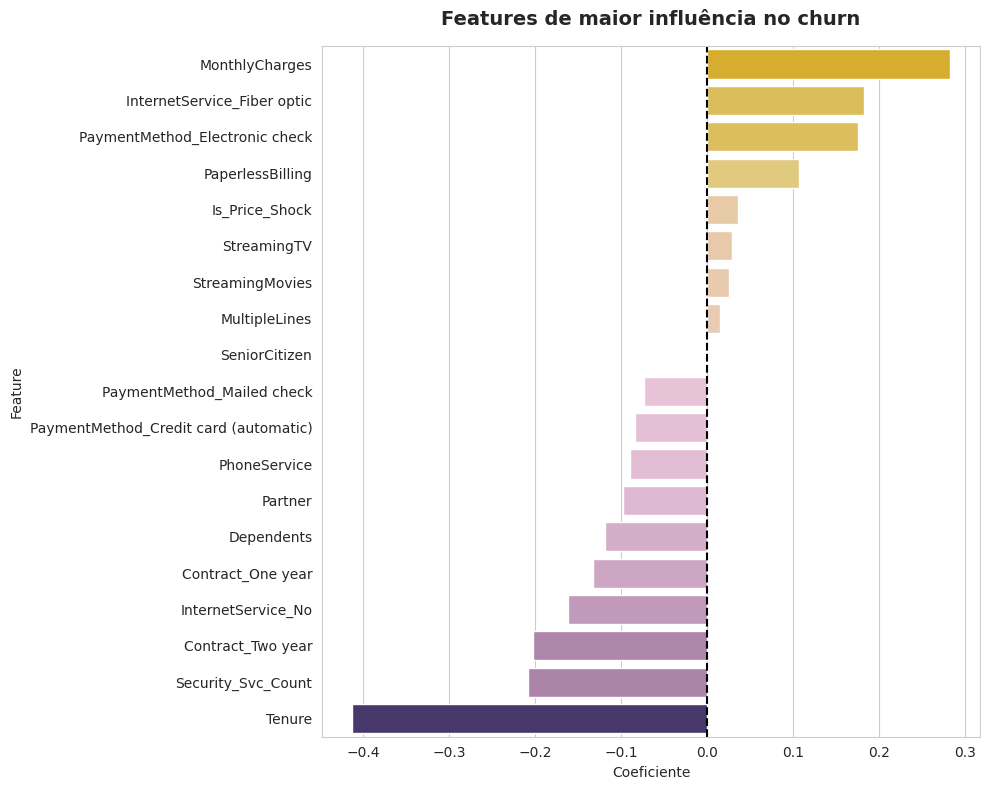

In [17]:
feature_names = df_train.drop(columns=['Churn']).columns
coeficientes = best_log_reg.coef_[0]

df_importancia = pd.DataFrame({
    'Feature': feature_names,
    'Coeficiente': coeficientes
})

df_importancia = df_importancia.sort_values(by='Coeficiente', ascending=False)

display(df_importancia.head(5))

display(df_importancia.tail(5).sort_values(by='Coeficiente', ascending=True))

#visualizaçao 
churn_palette = [
    '#442F73',  # Roxo Escuro (Base/Retenção)
    '#A56DA6',  # Roxo Médio 
    '#F2C2DC',  # Rosa Pastel 
    '#F2D16D',  # Amarelo Claro 
    '#F2BB13'   # Amarelo Ouro (Alerta/Churn)
]

meu_cmap = LinearSegmentedColormap.from_list("DegradeChurn", churn_palette)

norm = plt.Normalize(df_importancia['Coeficiente'].min(), df_importancia['Coeficiente'].max())
cores_exatas = [meu_cmap(norm(valor)) for valor in df_importancia['Coeficiente']]

plt.figure(figsize=(10, 8))

sns.barplot(
    data=df_importancia, 
    x='Coeficiente', 
    y='Feature', 
    palette=cores_exatas,
    hue='Feature',
    legend=False
)

plt.title('Features de maior influência no churn', fontsize=14, fontweight='bold', pad=15)

plt.axvline(0, color='black', linewidth=1.5, linestyle='--')

plt.tight_layout()
plt.show()